## Instalación e importación de librerías, y definición de constantes

In [ ]:
os.kill(os.getpid(), 9)

In [2]:
!pip install --force-reinstall numpy==1.26.4 --quiet
!pip install datasets --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
# Importación de librerías
#import sentencepiece as spm
import io
import time
import numpy as np

from torch.utils.data import DataLoader
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import AutoTokenizer
from transformers import AutoModel
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.utils import resample
from torch.utils.data import DataLoader, random_split

import re
from datasets import Dataset, DatasetDict

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

# Configurar semillas para facilitar la reproducibilidad de los resultados
seed = 99
torch.manual_seed(seed)
np.random.seed(seed)

## 1. Tokenización

### 1.1. Carga de los datos

In [4]:
data = pd.read_excel('Data_final.xlsx')

Veamos el contenido de los primeros 10 items del dataset:

In [5]:
display(data[0:10])

,ID,Texto,Categoria,Categoría de 1 a 5,Dataset
0,1,"- ¡Rápido, necesitamos sangre! - Yo soy 0 posi...",Humor,4.0,test
1,2,- ¿Cuál es el mejor portero del mundial? - Ev...,Humor,3.0,train-val
2,3,El otro día unas chicas llamarón a mi puerta y...,Humor,3.0,test
3,4,"- Andresito, ¿qué planeta va después de Marte?...",Humor,4.0,train-val
4,5,- ¿Por qué Bob Esponja no va al gimnasio? - P...,Humor,1.0,train-val
5,6,Van dos ciegos y le dice uno al otro: - Ojalá...,Humor,2.0,test
6,7,Noticia de última hora!! Muere una suegra at...,Humor,4.0,test
7,8,"– Mamá, mamá, en el colegio dicen que estoy lo...",Humor,3.0,train-val
8,9,"– Mamá, mamá, ¿me haces un bocata de jamón? – ...",Humor,1.0,test
9,10,- Qué pasa si te expulsan de cuatro univerdade...,Humor,2.0,test


In [6]:
print(data.shape)
data = data.drop_duplicates()
print(data.shape)

(11060, 5)
(11060, 5)


In [7]:
def preprocessing(text):
  #text = re.sub(r'[^a-zA-Z\s]', '', text)
  #text = re.sub(r'[.,]', '', text)
  text = text.lower()
  text = text.replace("\n", " ")
  return text

data["Texto"] = data["Texto"].apply(preprocessing)
display(data[0:10])

,ID,Texto,Categoria,Categoría de 1 a 5,Dataset
0,1,"- ¡rápido, necesitamos sangre! - yo soy 0 posi...",Humor,4.0,test
1,2,- ¿cuál es el mejor portero del mundial? - ev...,Humor,3.0,train-val
2,3,el otro día unas chicas llamarón a mi puerta y...,Humor,3.0,test
3,4,"- andresito, ¿qué planeta va después de marte?...",Humor,4.0,train-val
4,5,- ¿por qué bob esponja no va al gimnasio? - p...,Humor,1.0,train-val
5,6,van dos ciegos y le dice uno al otro: - ojalá...,Humor,2.0,test
6,7,noticia de última hora!! muere una suegra at...,Humor,4.0,test
7,8,"– mamá, mamá, en el colegio dicen que estoy lo...",Humor,3.0,train-val
8,9,"– mamá, mamá, ¿me haces un bocata de jamón? – ...",Humor,1.0,test
9,10,- qué pasa si te expulsan de cuatro univerdade...,Humor,2.0,test


Subdataset de 1000 - Comentar código para ejecutar con todo el dataset

In [8]:
# humor = data[data["Categoria"] == "Humor"]
# no_humor = data[data["Categoria"] == "No Humor"]

# # Tomar 500 ejemplos de cada clase
# humor_sample = resample(humor, n_samples=500, random_state=42, replace=False)
# no_humor_sample = resample(no_humor, n_samples=500, random_state=42, replace=False)

# # Combinar y mezclar los datos
# data = pd.concat([humor_sample, no_humor_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
data.shape

(11060, 5)

Ajuste al formato de la librería datasets

In [10]:
# Mapear categorías a números
label_map = {"Humor": 1, "No Humor": 0}
data["label"] = data["Categoria"].map(label_map)

# Seleccionar solo las columnas necesarias
data = data[["Texto", "label", "Dataset"]].rename(columns={"Texto": "text"})  # Formato compatible con datasets

In [11]:
data_train_val = data[data["Dataset"]=="train-val"]

In [12]:
display(data_train_val.shape)

(9060, 3)

In [13]:
# Dividir en train (80%), validación (10%) y test (10%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data_train_val["text"], data_train_val["label"], test_size=0.23, random_state=42, stratify=data_train_val["label"]
)

# Convertir a DataFrames
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df = pd.DataFrame({"text": val_texts, "label": val_labels})

test_df = data[data["Dataset"]=="test"]

In [14]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Ver estructura final
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 6976
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2084
    })
    test: Dataset({
        features: ['text', 'label', 'Dataset', '__index_level_0__'],
        num_rows: 2000
    })
})


### 1.2. Carga del tokenizador de distilbert

In [15]:
tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")

tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

#### 1.2.2 Ejemplo tokenización

In [16]:
encoded_text = tokenizer('Tokenizing text is a core task in NLP')
encoded_text

{'input_ids': [0, 106, 1702, 318, 439, 1194, 5003, 138, 4100, 320, 13021, 4343, 129, 374, 554, 24358, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['<s>',
 'T',
 'ok',
 'en',
 'iz',
 'ing',
 'Ġtex',
 't',
 'Ġis',
 'Ġa',
 'Ġcore',
 'Ġtas',
 'k',
 'Ġin',
 'ĠN',
 'LP',
 '</s>']

In [18]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

### 1.3 Tokenización del dataset

In [19]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6976 [00:00<?, ? examples/s]

Map:   0%|          | 0/2084 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Revisamos las nuevas columnas con las que contamos

In [20]:
dataset_encoded['train'].column_names

['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']

In [21]:
model_ckpt = "PlanTL-GOB-ES/roberta-base-bne"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Tamaño del modelo

In [22]:
# Parámetros totales
total_params = sum(p.numel() for p in model.parameters())

print(f"Model size: {total_params} parameters")

Model size: 124643328 parameters


Prueba tokenización

In [23]:
text = "this is a test"
sample_inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {sample_inputs['input_ids'].size()}\n"
      f"Tokenized text: {tokenizer.convert_ids_to_tokens(sample_inputs['input_ids'][0])}")

Input tensor shape: torch.Size([1, 6])
Tokenized text: ['<s>', 'this', 'Ġis', 'Ġa', 'Ġtest', '</s>']


Prueba pasando el ejemplo tokenizado al modelo

In [24]:
inputs = {k:v.to(device) for k,v in sample_inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    print(outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0851, -0.0965,  0.0264,  ..., -0.0307,  0.0274,  0.1414],
         [ 0.0201,  0.0386,  0.0061,  ...,  0.0030, -0.0159, -0.0740],
         [ 0.1046, -0.1884,  0.3244,  ..., -0.0510, -0.2375,  0.0309],
         [ 0.0589, -0.1432,  0.1262,  ...,  0.0275, -0.3645,  0.0158],
         [-0.1337, -0.0654, -0.1535,  ..., -0.2350,  0.1885, -0.2031],
         [-0.0504, -0.0554, -0.1497,  ...,  0.1109,  0.1550,  0.2287]]],
       device='cuda:0'), pooler_output=tensor([[ 0.0051, -0.1559, -0.0513, -0.0118,  0.0494, -0.0115,  0.1113, -0.0018,
         -0.0056, -0.1291,  0.1109,  0.0328, -0.0268,  0.0416, -0.0131, -0.0911,
          0.2692,  0.0951, -0.0735,  0.1334, -0.0330,  0.0452, -0.1217,  0.0272,
         -0.1765, -0.0143,  0.1319,  0.0695,  0.0125,  0.0322,  0.1333,  0.0997,
         -0.1498, -0.2649, -0.0730,  0.0572, -0.0816,  0.0286,  0.2073,  0.1122,
          0.0478, -0.0722, -0.0187,  0.0896, -0.1372,  0.0743,  0

In [25]:
outputs.last_hidden_state[:, 0].shape

torch.Size([1, 768])

Función que retorna solo el último estado oculto:

In [26]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
    if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

### 1.4 Codificación del dataset

In [27]:
dataset_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [28]:
dataset_hidden = dataset_encoded.map(
    extract_hidden_states, batched=True, batch_size=8)

Map:   0%|          | 0/6976 [00:00<?, ? examples/s]

Map:   0%|          | 0/2084 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [29]:
dataset_hidden["train"].column_names

['text',
 'label',
 '__index_level_0__',
 'input_ids',
 'attention_mask',
 'hidden state']

In [30]:
X_train = np.array(dataset_hidden["train"]["hidden state"])
X_valid = np.array(dataset_hidden["validation"]["hidden state"])
X_test = np.array(dataset_hidden["test"]["hidden state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])
print(X_train.shape, X_valid.shape, X_test.shape)

(6976, 768) (2084, 768) (2000, 768)


## 2. Clasificación de los textos

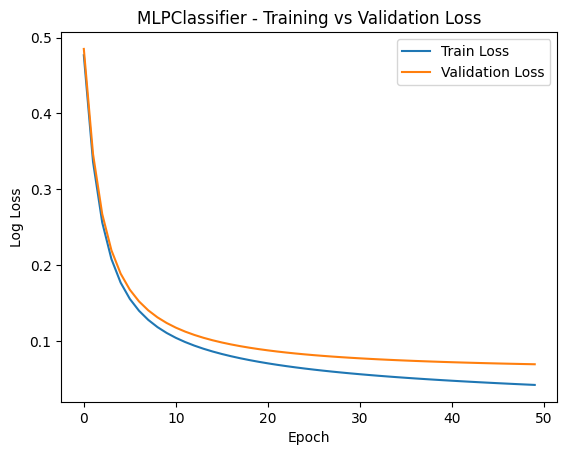

In [31]:
clf = MLPClassifier(hidden_layer_sizes=(20,), max_iter=1, warm_start=True, solver="adam", random_state=42)

train_losses = []
val_losses = []

classes = np.unique(y_train)

# Entrenar manualmente por época
for epoch in range(50):
    clf.partial_fit(X_train, y_train, classes=classes)  # 15 hl
    #clf.fit(X_train, y_train)  # 5-10 hl

    # Predicciones
    y_train_prob = clf.predict_proba(X_train)
    y_val_prob = clf.predict_proba(X_valid)

    # Cálculo de log-loss
    train_losses.append(log_loss(y_train, y_train_prob))
    val_losses.append(log_loss(y_valid, y_val_prob))

# Graficar
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("MLPClassifier - Training vs Validation Loss")
plt.legend()
plt.show()

In [32]:
y_pred = clf.predict(X_test)
target_names = ['No Humor', 'Humor']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.94      0.98      0.96       804
       Humor       0.98      0.96      0.97      1196

    accuracy                           0.97      2000
   macro avg       0.96      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



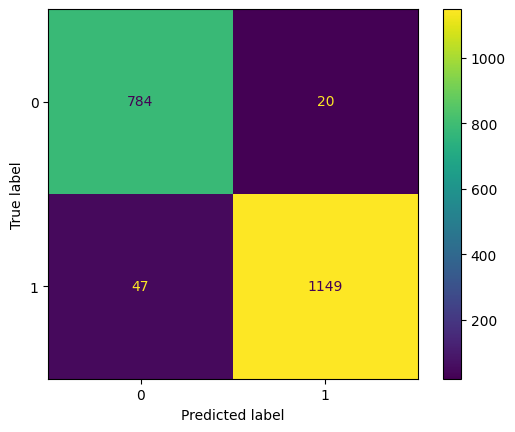

In [33]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [34]:
print(val_losses[-1])
print(train_losses[-1])

0.06948964133768906
0.04225884447810681


In [35]:
test_df_final = test_df.copy()
test_df_final ["Pred"] = y_pred
test_df_final  = test_df_final .drop("text", axis=1)
test_df_final = test_df_final .drop("Dataset", axis=1)
test_df_final

,label,Pred
0,1,1
2,1,1
5,1,1
6,1,1
8,1,1
...,...,...
10909,0,0
10917,0,0
10918,0,0
10920,0,0


In [36]:
test_df_final.to_csv("Results_RoBERTa.csv", index=True)

## 3. Pruebas de estrés

In [37]:
stress = pd.read_excel('stress_data_1.xlsx')

stress["Texto"] = stress["Texto"].apply(preprocessing)

# Mapear categorías a números
label_map = {"Humor": 1, "No Humor": 0}
stress["label"] = stress["Label"].map(label_map)

# Seleccionar solo las columnas necesarias
df_stress = stress[["Texto", "label"]].rename(columns={"Texto": "text"})  # Formato compatible con datasets

St_dataset = Dataset.from_pandas(df_stress)

St_encoded = St_dataset.map(tokenize, batched=True, batch_size=None)
St_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

St_hidden = St_encoded.map(extract_hidden_states, batched=True, batch_size=8)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [38]:
St_hidden.column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden state']

In [39]:
X_St = np.array(St_hidden["hidden state"])
Y_St = np.array(St_hidden["label"]).astype(int)

In [40]:
y_pred_st = clf.predict(X_St)
y_pred_st

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])

In [41]:
stress['Pred'] = y_pred_st

In [42]:
print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.74      0.56      0.64        50
       Humor       0.65      0.80      0.71        50

    accuracy                           0.68       100
   macro avg       0.69      0.68      0.68       100
weighted avg       0.69      0.68      0.68       100



In [43]:
stress.head(10)

,Ejemplos,Texto,Label,Clase_Contraria,Incoherentes,Repeticion,ofuscamiento,Largo,Corto,label,Pred
0,1,hombre le pregunta a su mujer como va a casa,No Humor,SI,NaN,NaN,NaN,NO,SI,0,1
1,2,"señor, ¿usted tiene hijos? —preguntó el niño. ...",No Humor,SI,NaN,NaN,NaN,SI,NO,0,1
2,3,un niño observaba a un hombre mayor en la plaz...,No Humor,SI,NaN,NaN,NaN,SI,NO,0,1
3,4,"jaimito le hace una pregunta a su madre: mamá,...",No Humor,SI,NaN,NaN,NaN,SI,NO,0,1
4,5,pregunta pregunta pregunta pregunta pregunta p...,No Humor,SI,NaN,NaN,NaN,NO,SI,0,0
5,6,entonces,No Humor,SI,NaN,NaN,NaN,NO,SI,0,0
6,7,jaimito volvió del colegio un día y le dijo a ...,No Humor,SI,NaN,NaN,NaN,SI,NO,0,1
7,8,un borracho llama a la puerta para preguntar p...,No Humor,SI,NaN,NaN,NaN,NO,SI,0,1
8,9,un amigo le preguntó a jaimito: ¿alguna vez te...,No Humor,SI,NaN,NaN,NaN,SI,NO,0,1
9,10,hombre,No Humor,SI,NaN,NaN,NaN,NO,SI,0,0


In [44]:
stress_contrary = stress[stress["Clase_Contraria"]=="SI"]

Y_St = stress_contrary["label"]
y_pred_st = stress_contrary["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.57      0.52      0.54        25
       Humor       0.71      0.75      0.73        40

    accuracy                           0.66        65
   macro avg       0.64      0.64      0.64        65
weighted avg       0.66      0.66      0.66        65



In [45]:
stress_incoherent = stress[stress["Incoherentes"]=="SI"]

Y_St = stress_incoherent["label"]
y_pred_st = stress_incoherent["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       1.00      0.50      0.67        10
       Humor       0.00      0.00      0.00         0

    accuracy                           0.50        10
   macro avg       0.50      0.25      0.33        10
weighted avg       1.00      0.50      0.67        10



In [46]:
stress_rep = stress[stress["Repeticion"]=="SI"]

Y_St = stress_rep["label"]
y_pred_st = stress_rep["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       1.00      1.00      1.00        10
       Humor       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [47]:
stress_ofus = stress[stress["ofuscamiento"]=="SI"]

Y_St = stress_ofus["label"]
y_pred_st = stress_ofus["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.00      0.00      0.00       5.0
       Humor       0.00      0.00      0.00       0.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



In [48]:
stress_long = stress[stress["Largo"]=="SI"]

Y_St = stress_long["label"]
y_pred_st = stress_long["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.38      0.26      0.31        19
       Humor       0.62      0.74      0.68        31

    accuracy                           0.56        50
   macro avg       0.50      0.50      0.49        50
weighted avg       0.53      0.56      0.54        50



In [49]:
stress_short = stress[stress["Corto"]=="SI"]

Y_St = stress_short["label"]
y_pred_st = stress_short["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.92      0.74      0.82        31
       Humor       0.68      0.89      0.77        19

    accuracy                           0.80        50
   macro avg       0.80      0.82      0.80        50
weighted avg       0.83      0.80      0.80        50



# Modelo Multiclase

In [50]:
data = pd.read_excel('Data_final.xlsx')

In [51]:
data_humor = data[data["Categoría de 1 a 5"].notna()]
print(data_humor.shape)

(6012, 5)


In [52]:
def preprocessing(text):
  #text = re.sub(r'[^a-zA-Z\s]', '', text)
  #text = re.sub(r'[.,]', '', text)
  text = text.lower()
  text = text.replace("\n", " ")
  return text

data_humor["Texto"] = data_humor["Texto"].apply(preprocessing)

In [53]:
# Mapear categorías a números
label_map = {1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5}
data_humor["label"] = data_humor["Categoría de 1 a 5"].map(label_map)

# Seleccionar solo las columnas necesarias
data_humor = data_humor[["Texto", "label", "Dataset"]].rename(columns={"Texto": "text"})  # Formato compatible con datasets

In [54]:
data_humor.head()

,text,label,Dataset
0,"- ¡rápido, necesitamos sangre! - yo soy 0 posi...",4,test
1,- ¿cuál es el mejor portero del mundial? - ev...,3,train-val
2,el otro día unas chicas llamarón a mi puerta y...,3,test
3,"- andresito, ¿qué planeta va después de marte?...",4,train-val
4,- ¿por qué bob esponja no va al gimnasio? - p...,1,train-val


In [55]:
data_humor["label"].value_counts()

,count
label,
3,2755
4,1413
2,1156
5,371
1,317


In [56]:
data_train_val = data_humor[data_humor["Dataset"]=="train-val"]

In [57]:
# Dividir en train (80%), validación (10%) y test (10%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data_train_val["text"], data_train_val["label"], test_size=0.23, random_state=42, stratify=data_train_val["label"]
)

# Convertir a DataFrames
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df = pd.DataFrame({"text": val_texts, "label": val_labels})

test_df = data_humor[data_humor["Dataset"]=="test"]

In [58]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Ver estructura final
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 3708
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1108
    })
    test: Dataset({
        features: ['text', 'label', 'Dataset', '__index_level_0__'],
        num_rows: 1196
    })
})


In [59]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/3708 [00:00<?, ? examples/s]

Map:   0%|          | 0/1108 [00:00<?, ? examples/s]

Map:   0%|          | 0/1196 [00:00<?, ? examples/s]

In [60]:
dataset_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [61]:
dataset_hidden = dataset_encoded.map(
    extract_hidden_states, batched=True, batch_size=16)

Map:   0%|          | 0/3708 [00:00<?, ? examples/s]

Map:   0%|          | 0/1108 [00:00<?, ? examples/s]

Map:   0%|          | 0/1196 [00:00<?, ? examples/s]

In [62]:
X_train = np.array(dataset_hidden["train"]["hidden state"])
X_valid = np.array(dataset_hidden["validation"]["hidden state"])
X_test = np.array(dataset_hidden["test"]["hidden state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])
print(X_train.shape, X_valid.shape, X_test.shape)

(3708, 768) (1108, 768) (1196, 768)


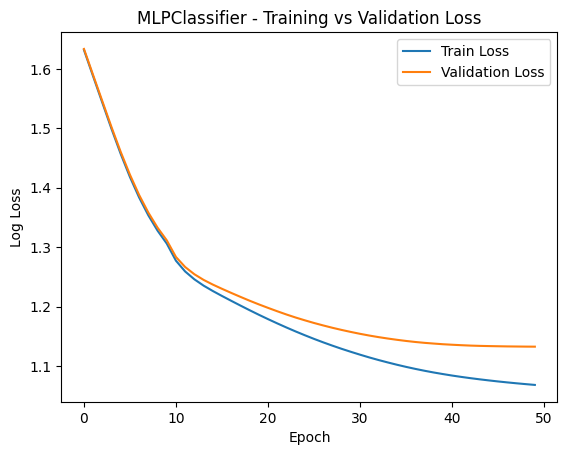

In [63]:
clf = MLPClassifier(hidden_layer_sizes=(5,), max_iter=1, warm_start=True, solver="adam", random_state=42)

train_losses = []
val_losses = []

classes = np.unique(y_train)

# Entrenar manualmente por época
for epoch in range(50):
    #clf.partial_fit(X_train, y_train, classes=classes)
    clf.fit(X_train, y_train)

    # Predicciones
    y_train_prob = clf.predict_proba(X_train)
    y_val_prob = clf.predict_proba(X_valid)

    # Cálculo de log-loss
    train_losses.append(log_loss(y_train, y_train_prob))
    val_losses.append(log_loss(y_valid, y_val_prob))

# Graficar
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("MLPClassifier - Training vs Validation Loss")
plt.legend()
plt.show()

In [64]:
y_pred = clf.predict(X_test)
target_names = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       114
           2       0.33      0.01      0.01       195
           3       0.36      0.75      0.49       434
           4       0.36      0.26      0.30       407
           5       0.00      0.00      0.00        46

    accuracy                           0.36      1196
   macro avg       0.21      0.20      0.16      1196
weighted avg       0.31      0.36      0.28      1196



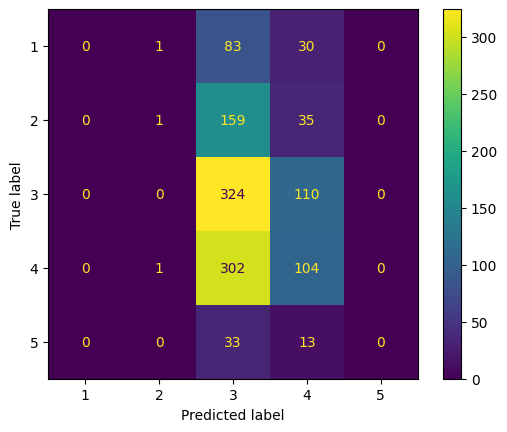

In [65]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()